In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

# Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 500 if 'CI' in os.environ else 2591

from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

train_cands = session.query(Spouse).filter(Spouse.split == 0).order_by(Spouse.id).all()
dev_cands   = session.query(Spouse).filter(Spouse.split == 1).order_by(Spouse.id).all()
test_cands  = session.query(Spouse).filter(Spouse.split == 2).order_by(Spouse.id).all()


In [2]:
from util import load_external_labels

#%time load_external_labels(session, Spouse, annotator_name='gold')

from snorkel.annotations import load_gold_labels

#L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
#L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [3]:
#gold_labels_dev = [x[0,0] for x in L_gold_dev.todense()]
#for i,L in enumerate(gold_labels_dev):
#    print(i,gold_labels_dev[i])

gold_labels_dev = []
for i,L in enumerate(L_gold_dev):
    gold_labels_dev.append(L[0,0])
    
gold_labels_test = []
for i,L in enumerate(L_gold_test):
    gold_labels_test.append(L[0,0])
    
print(len(gold_labels_dev),len(gold_labels_test))

(2796, 2697)


In [4]:
from gensim.parsing.preprocessing import STOPWORDS
import gensim.matutils as gm

from gensim.models.keyedvectors import KeyedVectors

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('../glove_w2v.txt', binary=False)  # C binary format


wordvec_unavailable= set()
def write_to_file(wordvec_unavailable):
    with open("wordvec_unavailable.txt","w") as f:
        for word in wordvec_unavailable:
            f.write(word+"\n")

def preprocess(tokens):
    btw_words = [word for word in tokens if word not in STOPWORDS]
    btw_words = [word for word in btw_words if word.isalpha()]
    return btw_words

def get_word_vectors(btw_words): # returns vector of embeddings of words
    word_vectors= []
    for word in btw_words:
        try:
            word_v = np.array(model[word])
            word_v = word_v.reshape(len(word_v),1)
            #print(word_v.shape)
            word_vectors.append(model[word])
        except:
            wordvec_unavailable.add(word)
    return word_vectors

def get_similarity(word_vectors,target_word): # sent(list of word vecs) to word similarity
    similarity = 0
    target_word_vector = 0
    try:
        target_word_vector = model[target_word]
    except:
        wordvec_unavailable.add(target_word+" t")
        return similarity
    target_word_sparse = gm.any2sparse(target_word_vector,eps=1e-09)
    for wv in word_vectors:
        wv_sparse = gm.any2sparse(wv, eps=1e-09)
        similarity = max(similarity,gm.cossim(wv_sparse,target_word_sparse))
    return similarity


In [5]:
##### Continuous ################

softmax_Threshold = 0.3
LF_Threshold = 0.3

import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)


spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    

def LF_husband_wife(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for sw in spouses:
        sc=max(sc,get_similarity(word_vectors,sw))
    return (1,sc)

def LF_husband_wife_left_window(c):
    global LF_Threshold
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for sw in spouses:
        sc_1=max(sc_1,get_similarity(word_vectors,sw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for sw in spouses:
        sc_2=max(sc_2,get_similarity(word_vectors,sw))
    return(1,max(sc_1,sc_2))
    
def LF_same_last_name(c):
    p1_last_name = last_name(c.person1.get_span())
    p2_last_name = last_name(c.person2.get_span())
    if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
        if c.person1.get_span() != c.person2.get_span():
            return (1,1)
    return (0,0)

def LF_no_spouse_in_sentence(c):
    return (-1,0.75) if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else (0,0)

def LF_and_married(c):
    global LF_Threshold
    word_vectors = get_word_vectors(preprocess(get_right_tokens(c)))
    sc = get_similarity(word_vectors,'married')
    
    if 'and' in get_between_tokens(c):
        return (1,sc)
    else:
        return (0,0)

def LF_familial_relationship(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for fw in family:
        sc=max(sc,get_similarity(word_vectors,fw))
        
    return (-1,sc) 

def LF_family_left_window(c):
    global LF_Threshold
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for fw in family:
        sc_1=max(sc_1,get_similarity(word_vectors,fw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for fw in family:
        sc_2=max(sc_2,get_similarity(word_vectors,fw))
        
    return (-1,max(sc_1,sc_2))

def LF_other_relationship(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for ow in other:
        sc=max(sc,get_similarity(word_vectors,ow))
        
    return (-1,sc) 

def LF_other_relationship_left_window(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c)))
    for ow in other:
        sc=max(sc,get_similarity(word_vectors,ow))
    return (-1,sc) 

import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# Read in known spouse pairs and save as set of tuples
with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
    known_spouses = set(
        tuple(strip_special(x).strip().split(',')) for x in f.readlines()
    )
# Last name pairs for known spouses
last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return (1,1) if (p1, p2) in known_spouses or (p2, p1) in known_spouses else (0,0)

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return (1,1) if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else (0,1)

import numpy as np

def LF_Three_Lists_Left_Window(c):
    global softmax_Threshold
    c1,s1 = LF_husband_wife_left_window(c)
    c2,s2 = LF_family_left_window(c)
    c3,s3 = LF_other_relationship_left_window(c)
    sc = np.array([s1,s2,s3])
    c = [c1,c2,c3]
    sharp_param = 1.5
    prob_sc = np.exp(sc * sharp_param - np.max(sc))
    prob_sc = prob_sc / np.sum(prob_sc)
    #print 'Left:',s1,s2,s3,prob_sc
    
    if s1==s2 or s3==s1:
        return (0,0)
    return c[np.argmax(prob_sc)],1

def LF_Three_Lists_Between_Words(c):
    global softmax_Threshold
    c1,s1 = LF_husband_wife(c)
    c2,s2 = LF_familial_relationship(c)
    c3,s3 = LF_other_relationship(c)
    sc = np.array([s1,s2,s3])
    c = [c1,c2,c3]
    sharp_param = 1.5
    
    prob_sc = np.exp(sc * sharp_param - np.max(sc))
    prob_sc = prob_sc / np.sum(prob_sc)
    #print 'BW:',s1,s2,s3,prob_sc
    if s1==s2 or s3==s1:
        return (0,0)
    return c[np.argmax(prob_sc)],1
    
LFs = [LF_distant_supervision, LF_distant_supervision_last_names,LF_same_last_name,
       LF_and_married, LF_Three_Lists_Between_Words,LF_Three_Lists_Left_Window, LF_no_spouse_in_sentence
      ]

In [6]:

import numpy as np
import math

def PHI(K,LAMDAi,SCOREi):
    return [K*l*s for (l,s) in zip(LAMDAi,SCOREi)]

def softmax(THETA,LAMDAi,SCOREi):
    x = []
    for k in [1,-1]:
        product = np.dot(PHI(k,LAMDAi,SCOREi),THETA)
        x.append(product)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def function_conf(THETA,LAMDA,P_cap,Confidence):
    s = 0.0
    i = 0
    for LAMDAi in LAMDA:
        s = s + Confidence[i]*np.dot(np.log(softmax(THETA,LAMDAi)),P_cap[i])
        i = i+1
    return -s

def function(THETA,LAMDA,SCORE,P_cap):
    s = 0.0
    i = 0
    for i in range(len(LAMDA)):
        s = s + np.dot(np.log(softmax(THETA,LAMDA[i],SCORE[i])),P_cap[i])
        i = i+1
    return -s

def P_K_Given_LAMDAi_THETA(K,THETA,LAMDAi,SCOREi):
    x = softmax(THETA,LAMDAi,SCOREi)
    if(K==1):
        return x[0]
    else:
        return x[1]
      

np.random.seed(78)
THETA = np.random.rand(len(LFs),1)

def PHIj(j,K,LAMDAi,SCOREi):
    return LAMDAi[j]*K*SCOREi[j]

def RIGHT(j,LAMDAi,SCOREi,THETA):
    phi = []
    for k in [1,-1]:
        phi.append(PHIj(j,k,LAMDAi,SCOREi))
    x = softmax(THETA,LAMDAi,SCOREi)
    return np.dot(phi,x)
    

def function_conf_der(THETA,LAMDA,P_cap,Confidence):
    der = []
    for j in range(len(THETA)):
        i = 0
        s = 0.0
        for LAMDAi in LAMDA:
            p = 0
            for K in [1,-1]:
                s = s + Confidence[i]*(PHIj(j,K,LAMDAi)-RIGHT(j,LAMDAi,THETA))*P_cap[i][p]
                p = p+1
            i = i+1
        der.append(-s)
    return np.array(der)

def function_der(THETA,LAMDA,SCORE,P_cap):
    der = []
    for j in range(len(THETA)):
        i = 0
        s = 0.0
        for index in range(len(LAMDA)):
            p = 0
            for K in [1,-1]:
                s = s + (PHIj(j,K,LAMDA[index],SCORE[index])-RIGHT(j,LAMDA[index],SCORE[index],THETA))*P_cap[i][p]
                p = p+1
            i = i+1
        der.append(-s)
    return np.array(der)


import numpy as np


def get_LAMDA(cands):
    LAMDA = []
    SCORE = []
    for ci in cands:
        L=[]
        S=[]
        P_ik = []
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        LAMDA.append(L)
        SCORE.append(S) 
    return LAMDA,SCORE

def get_Confidence(LAMDA):
    confidence = []
    for L in LAMDA:
        Total_L = float(len(L))
        No_zeros = L.count(0)
        No_Non_Zeros = Total_L - No_zeros
        confidence.append(No_Non_Zeros/Total_L)
    return confidence    
    
def get_Initial_P_cap(LAMDA):
    P_cap = []
    for L in LAMDA:
        P_ik = []
        denominator=float(L.count(1)+L.count(-1))
        if(denominator==0):
            denominator=1
        P_ik.append(L.count(1)/denominator)
        P_ik.append(L.count(-1)/denominator)
        P_cap.append(P_ik)
    return P_cap
    #print(np.array(LAMDA))
    #print(np.array(P_cap))append(L)
    #LAMDA=np.array(LAMDA).astype(int)
    #P_cap=np.array(P_cap)
    #print(np.array(LAMDA).shape)
    #print(np.array(P_cap).shape)
    #print(L)
    #print(ci.chemical.get_span(),ci.disease.get_span(),"No.Os",L.count(0),"No.1s",L.count(1),"No.-1s",L.count(-1))
    #print(ci.chemical.get_span(),ci.disease.get_span(),"P(0):",L.count(0)/len(L)," P(1)",L.count(1)/len(L),"P(-1)",L.count(-1)/len(L))

        
def get_P_cap(LAMDA,SCORE,THETA):
    P_cap = []
    for i in range(len(LAMDA)):
        P_capi = softmax(THETA,LAMDA[i],SCORE[i])
        P_cap.append(P_capi)
    return P_cap


def score(predicted_labels,gold_labels):
    tp =0.0
    tn =0.0
    fp =0.0
    fn =0.0
    for i in range(len(gold_labels)):
        if(predicted_labels[i]==gold_labels[i]):
            if(predicted_labels[i]==1):
                tp=tp+1
            else:
                tn=tn+1
        else:
            if(predicted_labels[i]==1):
                fp=fp+1
            else:
                fn=fn+1
    print("tp",tp,"tn",tn,"fp",fp,"fn",fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1score = (2*precision*recall)/(precision+recall)
    print("precision:",precision)
    print("recall:",recall)
    print("F1 score:",f1score)
                
           
    
from scipy.optimize import minimize
import cPickle as pickle

def get_marginals(P_cap):
    marginals = []
    for P_capi in P_cap:
        marginals.append(P_capi[0])
    return marginals

def predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<0.5):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)
    return predicted_labels

def print_details(label,THETA,LAMDA,SCORE):
    print(label)
    P_cap = get_P_cap(LAMDA,SCORE,THETA)
    marginals=get_marginals(P_cap)
    plt.hist(marginals, bins=20)
    plt.show()
    plt.bar(range(0,2796),marginals)
    plt.show()
    predicted_labels=predict_labels(marginals)
    print(len(marginals),len(predicted_labels),len(gold_labels_dev))
    #score(predicted_labels,gold_labels_dev)
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
    
    
    
def train(No_Iter,Use_Confidence=True,theta_file_name="THETA"):
    global THETA
    global dev_LAMDA,dev_SCORE
    LAMDA,SCORE = get_LAMDA(train_cands)
    P_cap = get_Initial_P_cap(LAMDA)
    Confidence = get_Confidence(LAMDA)
    for iteration in range(No_Iter):
        if(Use_Confidence==True):
            res = minimize(function_conf,THETA,args=(LAMDA,P_cap,Confidence), method='BFGS',jac=function_conf_der,options={'disp': True, 'maxiter':20}) #nelder-mead
        else:
            res = minimize(function,THETA,args=(LAMDA,SCORE,P_cap), method='BFGS',jac=function_der,options={'disp': True, 'maxiter':20}) #nelder-mead            
        THETA = res.x # new THETA
        print(THETA)
        P_cap = get_P_cap(LAMDA,SCORE,THETA) #new p_cap 
        print_details("train iteration: "+str(iteration),THETA,dev_LAMDA,dev_SCORE)
        #score(predicted_labels,gold_labels)
    NP_P_cap = np.array(P_cap)
    np.savetxt('Train_P_cap.txt', NP_P_cap, fmt='%f')
    pickle.dump(NP_P_cap,open("Train_P_cap.p","wb"))
    NP_THETA = np.array(THETA)
    np.savetxt(theta_file_name+'.txt', NP_THETA, fmt='%f') 
    pickle.dump( NP_THETA, open( theta_file_name+'.p', "wb" )) # save the file as "outfile_name.npy" 

        
def test(THETA):
    global dev_LAMDA,dev_SCORE
    P_cap = get_P_cap(dev_LAMDA,dev_SCORE,THETA)
    print_details("test:",THETA,dev_LAMDA,dev_SCORE)
    NP_P_cap = np.array(P_cap)
    np.savetxt('Dev_P_cap.txt', NP_P_cap, fmt='%f')
    pickle.dump(NP_P_cap,open("Dev_P_cap.p","wb"))
                    
def load_marginals(s):
    marginals = []
    if(s=="train"):
        train_P_cap = np.load("Train_P_cap.npy")
        marginals = train_P_cap[:,0]
    return marginals



In [112]:
''' output:

    [[[L_x1],[S_x1]],
     [[L_x2],[S_x2]],
     ......
     ......
    ]

'''
def get_L_S_Tensor(cands): 
    
    L_S = []
    for ci in cands:
        L_S_ci=[]
        L=[]
        S=[]
        P_ik = []
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        L_S_ci.append(L)
        L_S_ci.append(S)
        L_S.append(L_S_ci) 
    return L_S

def get_L_S(cands):  # sign gives label abs value gives score
    
    L_S = []
    for ci in cands:
        l_s=[]
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            s= (s+1)/2  #to scale scores in [0,1] 
            l_s.append(l*s)
        L_S.append(l_s)
    return L_S

def get_Initial_P_cap_L_S(L_S):
    P_cap = []
    for L,S in L_S:
        P_ik = []
        denominator=float(L.count(1)+L.count(-1))
        if(denominator==0):
            denominator=1
        P_ik.append(L.count(1)/denominator)
        P_ik.append(L.count(-1)/denominator)
        P_cap.append(P_ik)
    return P_cap



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
   
    

#L_S = get_L_S_Tensor(train_cands)


#dev_L_S = get_L_S_Tensor(dev_cands)
#train_L_S = get_L_S_Tensor(train_cands)
test_L_S = get_L_S_Tensor(test_cands)

#dev_L_S = get_L_S_Tensor(dev_cands)
#train_L_S = get_L_S_Tensor(train_cands)

#train_P_cap= get_Initial_P_cap_L_S(train_L_S) 

#dev_P_cap = get_Initial_P_cap_L_S(dev_L_S)

test_P_cap = get_Initial_P_cap_L_S(test_L_S)

In [135]:
import cPickle as pkl

#pkl.dump(dev_L_S,open("dev_L_S.p","wb"))
#pkl.dump(train_L_S,open("train_L_S.p","wb"))
#pkl.dump(train_P_cap,open("train_P_cap.p","wb"))
#pkl.dump(dev_P_cap,open("dev_P_cap.p","wb"))
pkl.dump(test_L_S,open("test_L_S.p","wb"))
pkl.dump(test_P_cap,open("test_P_cap.p","wb"))

#dev_L_S = pkl.load( open( "dev_L_S.p", "rb" ) )
#train_L_S = pkl.load( open( "train_L_S.p", "rb" ) )
#P_cap = pkl.load( open( "P_cap.p", "rb" ) )


In [131]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

result_dir = "./"
config = projector.ProjectorConfig()
tf.logging.set_verbosity(tf.logging.INFO)
summary_writer = tf.summary.FileWriter(result_dir)
projector.visualize_embeddings(summary_writer, config)

tf.reset_default_graph()



dim = 2 #(labels,scores)

_x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))
_p_cap = tf.placeholder(tf.float64,shape=(2))

alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                        dtype=tf.float64)

thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.0),
                        dtype=tf.float64)

#print([n.name for n in tf.get_default_graph().as_graph_def().node])

#for k = 1

k_p1 = tf.ones(shape=(dim,len(LFs)),dtype=tf.float64)

k_n1 = tf.negative(k_p1)


l,s = tf.unstack(_x)

prelu_out_s = tf.maximum(tf.subtract(tf.abs(s),alphas,name='subtract'), 0,name='max')        


mul_L_S = tf.multiply(l,prelu_out_s)

phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

phi_n1 = tf.reduce_sum(tf.multiply(tf.multiply(mul_L_S,k_n1),thetas))

phi_out = tf.stack([phi_p1,phi_n1])

loss = tf.negative(tf.reduce_sum(tf.multiply(tf.log(tf.nn.softmax(phi_out)),_p_cap))) - tf.reduce_sum(tf.multiply(alphas,alphas))

predict = tf.argmax(tf.nn.softmax(phi_out))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss) 

check_op = tf.add_check_numerics_ops()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)


for i in range(1):
    for L_S_i,P_cap_i in zip(train_L_S,dev_P_cap):
        te=100
        te_t,_ = sess.run([loss,train_step],feed_dict={_x:L_S_i,_p_cap:P_cap_i})
        if(te-te_1<e-10):
            break
    for L_S_i,P_cap_i in zip(dev_L_S,dev_P_cap)
        
        
        
        
        





    


0.41314718056
0.398444012972
0.370114216378
0.349771591245
0.329658566684
0.310079705031
0.239432872653
0.231176176868
0.29616079264
0.295467235574
0.279465131097
0.115744239981
0.115463829694
0.117004461216
0.122378817642
0.195938431831
0.0816859212308
-0.0575917432294
-0.0466704979595
0.130623859465
0.0877283212783
0.0412350407075
-0.063940519536
-0.090749331375
-0.118432268783
-0.0951524405938
-0.315129769979
-0.356514982702
-0.397990448264
-0.439674240757
-0.31148303213
-0.224204820676
-0.551420482844
-0.422135054123
-0.63555811848
-0.62218252214
-0.481491566607
-0.518779467371
-0.815743924849
-0.867251068133
-0.864729434455
-0.973357043111
-1.02872014216
-1.08552673846
-0.818546553688
-1.14657336046
-0.943183718118
-1.27266597736
-1.07540600383
-1.27835910994
-1.47925948276
-1.55418906061
-1.36135704574
-1.50062095218
-1.55337529673
-1.61983142279
-2.00585568589
-1.81762452375
-1.89501335108
-2.12192044243
-2.39034923145
-2.22261755683
-2.34064945329
-2.46222833349
-2.63433639361


-824686859.855
-858004208.269
-892667577.528
-928731346.875
-966252092.469
-1005288676.15
-1045902337.78
-1088156791.3
-1132118324.7
-1177855904.02
-1225441281.49
-1274949108.18
-1326457051.01
-1380045914.69
-1435799768.41
-1493806077.78
-1554155841.99
-1616943736.61
-1682268262.12
-1750231898.41
-1820941265.54
-1894507291.03
-1971045383.89
-2050675615.63
-2133522908.66
-2219717232.25
-2309393806.44
-2402693314.14
-2499762121.87
-2600752509.34
-2705822908.37
-2815138151.43
-2928869730.21
-3047196064.67
-3170302782.93
-3298383012.5
-3431637683.22
-3570275842.52
-3714514983.33
-3864581385.3
-4020710469.77
-4183147169.11
-4352146310.95
-4527973017.97
-4710903123.8
-4901223605.73
-5099233034.96
-5305242044.95
-5519573818.76
-5742564596.03
-5974564200.5
-6215936588.78
-6467060421.33
-6728329656.48
-7000154168.49
-7282960390.55
-7577191983.71
-7883310532.97
-8201796271.34
-8533148833.25
-8877888038.36
-9236554707.04
-9609711508.81
-9997943845.03
-10401860767.3
-10822095932.8
-11259308598.7
-

-1.74283051943e+17
-1.81324087083e+17
-1.88649580036e+17
-1.96271022897e+17
-2.04200372043e+17
-2.12450066888e+17
-2.21033049396e+17
-2.2996278439e+17
-2.3925328067e+17
-2.48919112991e+17
-2.58975444929e+17
-2.69438052667e+17
-2.80323349749e+17
-2.91648412824e+17
-3.03431008436e+17
-3.156896209e+17
-3.28443481296e+17
-3.41712597641e+17
-3.55517786274e+17
-3.69880704516e+17
-3.84823884641e+17
-4.00370769229e+17
-4.16545747941e+17
-4.33374195778e+17
-4.50882512892e+17
-4.69098166002e+17
-4.88049731481e+17
-5.07766940187e+17
-5.28280724108e+17
-5.4962326488e+17
-5.7182804428e+17
-5.94929896747e+17
-6.18965064033e+17
-6.43971252056e+17
-6.69987690052e+17
-6.97055192119e+17
-7.25216221245e+17
-7.54514955922e+17
-7.84997359453e+17
-8.16711252059e+17
-8.49706385897e+17
-8.84034523112e+17
-9.1974951704e+17
-9.5690739669e+17
-9.95566454643e+17
-1.0357873385e+18
-1.07763314603e+18
-1.12116952415e+18
-1.1664647719e+18
-1.21358994763e+18
-1.2626189804e+18
-1.31362878606e+18
-1.36669938782e+18
-1.4

-3.98677681546e+25
-4.14784259517e+25
-4.31541543223e+25
-4.48975821176e+25
-4.67114443942e+25
-4.85985867051e+25
-5.05619695637e+25
-5.2604673088e+25
-5.47299018328e+25
-5.69409898169e+25
-5.92414057536e+25
-6.1634758492e+25
-6.41248026788e+25
-6.67154446486e+25
-6.94107485516e+25
-7.22149427297e+25
-7.51324263502e+25
-7.81677763062e+25
-8.13257543977e+25
-8.46113148012e+25
-8.8029611842e+25
-9.15860080801e+25
-9.5286082723e+25
-9.91356403782e+25
-1.03140720159e+26
-1.07307605159e+26
-1.1164283231e+26
-1.16153202633e+26
-1.20845791914e+26
-1.25727961797e+26
-1.30807371339e+26
-1.36091989022e+26
-1.41590105254e+26
-1.47310345377e+26
-1.53261683196e+26
-1.59453455058e+26
-1.65895374497e+26
-1.72597547475e+26
-1.79570488235e+26
-1.86825135796e+26
-1.94372871112e+26
-2.02225534928e+26
-2.10395446355e+26
-2.18895422195e+26
-2.27738797052e+26
-2.36939444246e+26
-2.46511797577e+26
-2.56470873974e+26
-2.66832297049e+26
-2.77612321607e+26
-2.88827859146e+26
-3.00496504392e+26
-3.12636562896e+2

-1.52613570277e+34
-1.58779158377e+34
-1.6519383623e+34
-1.71867667064e+34
-1.78811120656e+34
-1.86035089768e+34
-1.93550907225e+34
-2.013703637e+34
-2.0950572621e+34
-2.17969757358e+34
-2.26775735356e+34
-2.35937474858e+34
-2.45469348627e+34
-2.55386310087e+34
-2.65703916782e+34
-2.76438354778e+34
-2.87606464059e+34
-2.99225764944e+34
-3.11314485575e+34
-3.23891590508e+34
-3.3697681047e+34
-3.50590673305e+34
-3.64754536187e+34
-3.79490619116e+34
-3.94822039783e+34
-4.1077284983e+34
-4.27368072588e+34
-4.44633742331e+34
-4.62596945116e+34
-4.81285861277e+34
-5.00729809633e+34
-5.20959293486e+34
-5.42006048468e+34
-5.63903092331e+34
-5.86684776747e+34
-6.10386841193e+34
-6.3504646902e+34
-6.6070234579e+34
-6.87394719957e+34
-7.15165466017e+34
-7.44058150191e+34
-7.74118098781e+34
-8.05392469265e+34
-8.37930324289e+34
-8.71782708626e+34
-9.0700272926e+34
-9.43645638695e+34
-9.81768921637e+34
-1.02143238518e+35
-1.06269825261e+35
-1.10563126104e+35
-1.15029876298e+35
-1.19677083196e+35
-1

-1.92732419257e+42
-2.0051880882e+42
-2.08619768513e+42
-2.17048006971e+42
-2.25816746254e+42
-2.34939742597e+42
-2.44431307984e+42
-2.54306332603e+42
-2.64580308209e+42
-2.75269352419e+42
-2.86390234006e+42
-2.97960399198e+42
-3.09997999054e+42
-3.22521917933e+42
-3.35551803124e+42
-3.49108095664e+42
-3.6321206241e+42
-3.778858294e+42
-3.93152416564e+42
-4.09035773834e+42
-4.25560818724e+42
-4.42753475412e+42
-4.60640715415e+42
-4.79250599898e+42
-4.98612323697e+42
-5.1875626112e+42
-5.39714013596e+42
-5.61518459253e+42
-5.84203804494e+42
-6.07805637663e+42
-6.32360984871e+42
-6.57908368083e+42
-6.84487865553e+42
-7.12141174697e+42
-7.40911677506e+42
-7.70844508601e+42
-8.01986626046e+42
-8.34386885007e+42
-8.680961144e+42
-9.0316719663e+42
-9.3965515055e+42
-9.77617217776e+42
-1.01711295248e+43
-1.05820431483e+43
-1.10095576819e+43
-1.14543438022e+43
-1.19170992814e+43
-1.23985500815e+43
-1.28994514934e+43
-1.3420589322e+43
-1.39627811184e+43
-1.45268774628e+43
-1.51137632991e+43
-1.

-6.05235349526e+50
-6.29686857095e+50
-6.55126205547e+50
-6.81593303654e+50
-7.091296725e+50
-7.37778510622e+50
-7.67584761778e+50
-7.98595185454e+50
-8.30858430218e+50
-8.64425110041e+50
-8.99347883699e+50
-9.3568153738e+50
-9.73483070637e+50
-1.0128117858e+51
-1.05372938103e+51
-1.09630004706e+51
-1.14059056796e+51
-1.18667042586e+51
-1.23461190999e+51
-1.28449023003e+51
-1.33638363415e+51
-1.39037353175e+51
-1.44654462116e+51
-1.50498502254e+51
-1.56578641608e+51
-1.62904418586e+51
-1.69485756948e+51
-1.76332981374e+51
-1.83456833661e+51
-1.90868489573e+51
-1.98579576378e+51
-2.06602191083e+51
-2.14948919414e+51
-2.23632855562e+51
-2.32667622723e+51
-2.42067394469e+51
-2.51846916985e+51
-2.62021532201e+51
-2.72607201863e+51
-2.8362053257e+51
-2.95078801827e+51
-3.06999985152e+51
-3.19402784272e+51
-3.32306656465e+51
-3.45731845084e+51
-3.5969941131e+51
-3.74231267199e+51
-3.89350210052e+51
-4.05079958183e+51
-4.21445188124e+51
-4.3847157334e+51
-4.56185824503e+51
-4.74615731397e+51


-1.27905837847e+59
-1.33073233579e+59
-1.38449392094e+59
-1.44042747408e+59
-1.49862074272e+59
-1.55916501936e+59
-1.62215528472e+59
-1.68769035675e+59
-1.75587304562e+59
-1.82681031506e+59
-1.90061345012e+59
-1.97739823178e+59
-2.05728511854e+59
-2.14039943545e+59
-2.22687157069e+59
-2.31683718012e+59
-2.41043740008e+59
-2.50781906884e+59
-2.60913495694e+59
-2.71454400682e+59
-2.82421158222e+59
-2.93830972757e+59
-3.05701743788e+59
-3.18052093958e+59
-3.30901398264e+59
-3.44269814452e+59
-3.58178314642e+59
-3.72648718227e+59
-3.87703726103e+59
-4.03366956284e+59
-4.19662980951e+59
-4.36617364998e+59
-4.54256706146e+59
-4.7260867666e+59
-4.91702066766e+59
-5.11566829815e+59
-5.32234129273e+59
-5.5373638761e+59
-5.76107337165e+59
-5.99382073061e+59
-6.23597108266e+59
-6.48790430871e+59
-6.75001563687e+59
-7.02271626244e+59
-7.30643399304e+59
-7.60161391969e+59
-7.90871911512e+59
-8.22823136016e+59
-8.5606518996e+59
-8.90650222854e+59
-9.26632491045e+59
-9.64068442838e+59
-1.00301680705e

-2.40024414376e+67
-2.49721400498e+67
-2.5981014485e+67
-2.70306474465e+67
-2.81226855787e+67
-2.92588420505e+67
-3.04408992426e+67
-3.16707115443e+67
-3.29502082618e+67
-3.42813966455e+67
-3.56663650387e+67
-3.71072861538e+67
-3.86064204805e+67
-4.01661198327e+67
-4.17888310373e+67
-4.34770997731e+67
-4.52335745643e+67
-4.70610109355e+67
-4.89622757344e+67
-5.09403516294e+67
-5.29983417887e+67
-5.51394747487e+67
-5.73671094782e+67
-5.96847406488e+67
-6.20960041166e+67
-6.46046826263e+67
-6.72147117455e+67
-6.99301860387e+67
-7.27553654909e+67
-7.56946821904e+67
-7.87527472819e+67
-8.19343582002e+67
-8.52445061968e+67
-8.86883841694e+67
-9.2271394809e+67
-9.59991590751e+67
-9.98775250142e+67
-1.03912576934e+68
-1.08110644947e+68
-1.12478314904e+68
-1.17022438724e+68
-1.21750145142e+68
-1.26668850894e+68
-1.31786272355e+68
-1.37110437638e+68
-1.42649699193e+68
-1.48412746911e+68
-1.54408621751e+68
-1.60646729928e+68
-1.67136857671e+68
-1.73889186569e+68
-1.80914309547e+68
-1.88223247488

-7.24476976424e+75
-7.53745845611e+75
-7.84197177086e+75
-8.15878742325e+75
-8.48840242771e+75
-8.83133387805e+75
-9.18811975867e+75
-9.55931978854e+75
-9.94551629928e+75
-1.03473151487e+76
-1.07653466713e+76
-1.1200266667e+76
-1.16527574301e+76
-1.21235288197e+76
-1.26133193729e+76
-1.31228974641e+76
-1.36530625097e+76
-1.42046462226e+76
-1.4778513917e+76
-1.53755658658e+76
-1.59967387128e+76
-1.66430069422e+76
-1.73153844075e+76
-1.80149259217e+76
-1.87427289125e+76
-1.94999351435e+76
-2.02877325055e+76
-2.11073568802e+76
-2.1960094079e+76
-2.28472818597e+76
-2.3770312026e+76
-2.47306326102e+76
-2.57297501451e+76
-2.67692320275e+76
-2.7850708977e+76
-2.89758775943e+76
-3.01465030226e+76
-3.13644217173e+76
-3.2631544326e+76
-3.3949858687e+76
-3.5321432947e+76
-3.67484188059e+76
-3.82330548921e+76
-3.97776702749e+76
-4.13846881177e+76
-4.305662948e+76
-4.47961172717e+76
-4.66058803686e+76
-4.8488757893e+76
-5.04477036677e+76
-5.24857908498e+76
-5.46062167523e+76
-5.68123078593e+76
-5.9

-1.72421611196e+84
-1.79387444132e+84
-1.86634696711e+84
-1.94174738288e+84
-2.02019397537e+84
-2.10180981014e+84
-2.18672292455e+84
-2.27506652871e+84
-2.36697921439e+84
-2.4626051725e+84
-2.56209441922e+84
-2.66560303142e+84
-2.77329339146e+84
-2.88533444194e+84
-3.00190195077e+84
-3.12317878684e+84
-3.24935520698e+84
-3.38062915438e+84
-3.51720656913e+84
-3.65930171132e+84
-3.80713749712e+84
-3.96094584853e+84
-4.1209680572e+84
-4.28745516295e+84
-4.46066834762e+84
-4.6408793448e+84
-4.8283708661e+84
-5.02343704469e+84
-5.22638389671e+84
-5.43752980137e+84
-5.65720600039e+84
-5.88575711764e+84
-6.12354169983e+84
-6.37093277892e+84
-6.62831845738e+84
-6.89610251701e+84
-7.17470505241e+84
-7.46456312998e+84
-7.76613147363e+84
-8.07988317808e+84
-8.4063104511e+84
-8.74592538566e+84
-9.09926076327e+84
-9.46687088981e+84
-9.84933246512e+84
-1.02472454877e+85
-1.06612341961e+85
-1.10919480479e+85
-1.15400627389e+85
-1.2006281263e+85
-1.24913350151e+85
-1.29959849383e+85
-1.3521022718e+85


-1.40847630408e+92
-1.46537874548e+92
-1.52458004546e+92
-1.58617307791e+92
-1.65025446881e+92
-1.71692474784e+92
-1.78628850609e+92
-1.85845456011e+92
-1.93353612264e+92
-2.01165098023e+92
-2.092921678e+92
-2.17747571188e+92
-2.26544572866e+92
-2.35696973403e+92
-2.45219130913e+92
-2.55125983578e+92
-2.65433073082e+92
-2.76156568993e+92
-2.87313294128e+92
-2.98920750949e+92
-3.10997149015e+92
-3.23561433551e+92
-3.36633315172e+92
-3.50233300798e+92
-3.64382725831e+92
-3.79103787622e+92
-3.94419580296e+92
-4.1035413098e+92
-4.26932437498e+92
-4.44180507583e+92
-4.62125399685e+92
-4.8079526541e+92
-5.00219393695e+92
-5.20428256744e+92
-5.41453557841e+92
-5.63328281084e+92
-5.86086743127e+92
-6.09764647014e+92
-6.34399138198e+92
-6.60028862802e+92
-6.86694028258e+92
-7.14436466373e+92
-7.43299698963e+92
-7.73329006123e+92
-8.04571497265e+92
-8.37076185021e+92
-8.70894062133e+92
-9.06078181449e+92
-9.42683739153e+92
-9.80768161355e+92
-1.02039119418e+93
-1.06161499749e+93
-1.10450424242e+

-4.62699998893e+99
-4.81393078427e+99
-5.00841358356e+99
-5.21075348777e+99
-5.42126792392e+99
-5.64028714311e+99
-5.86815473854e+99
-6.10522818463e+99
-6.35187939772e+99
-6.6084953196e+99
-6.87547852448e+99
-7.1532478506e+99
-7.44223905724e+99
-7.74290550837e+99
-8.05571888384e+99
-8.3811699194e+99
-8.71976917651e+99
-9.07204784328e+99
-9.43855856788e+99
-9.81987632541e+99
-1.021659932e+100
-1.06293499232e+100
-1.10587756504e+100
-1.15055501766e+100
-1.19703743933e+100
-1.24539775078e+100
-1.29571181878e+100
-1.34805857508e+100
-1.40252014028e+100
-1.45918195267e+100
-1.51813290222e+100
-1.57946547009e+100
-1.64327587364e+100
-1.70966421744e+100
-1.77873465026e+100
-1.85059552851e+100
-1.92535958618e+100
-2.0031441117e+100
-2.08407113199e+100
-2.16826760382e+100
-2.25586561304e+100
-2.34700258175e+100
-2.44182148391e+100
-2.54047106963e+100
-2.64310609853e+100
-2.7498875825e+100
-2.86098303832e+100
-2.97656675046e+100
-3.09682004447e+100
-3.22193157144e+100
-3.35209760399e+100
-3.4875

-1.24013121348e+108
-1.29023251337e+108
-1.34235790573e+108
-1.3965891639e+108
-1.45301136485e+108
-1.51171302266e+108
-1.5727862274e+108
-1.63632678955e+108
-1.70243439036e+108
-1.77121273818e+108
-1.84276973118e+108
-1.91721762664e+108
-1.99467321701e+108
-2.07525801316e+108
-2.159098435e+108
-2.2463260098e+108
-2.33707757855e+108
-2.43149551059e+108
-2.52972792701e+108
-2.63192893295e+108
-2.73825885944e+108
-2.84888451486e+108
-2.96397944667e+108
-3.08372421361e+108
-3.20830666903e+108
-3.33792225553e+108
-3.47277431161e+108
-3.61307439063e+108
-3.75904259272e+108
-3.91090791004e+108
-4.06890858603e+108
-4.2332924892e+108
-4.4043175019e+108
-4.58225192496e+108
-4.76737489855e+108
-4.95997684011e+108
-5.16035989992e+108
-5.36883843517e+108
-5.58573950306e+108
-5.81140337389e+108
-6.04618406489e+108
-6.2904498956e+108
-6.54458406565e+108
-6.80898525593e+108
-7.08406825406e+108
-7.37026460507e+108
-7.66802328839e+108
-7.97781142225e+108
-8.30011499643e+108
-8.63543963472e+108
-8.98431

-1.39068326843e+116
-1.44686687121e+116
-1.50532029149e+116
-1.56613522989e+116
-1.62940709175e+116
-1.69523513677e+116
-1.76372263475e+116
-1.83497702759e+116
-1.90911009783e+116
-1.98623814404e+116
-2.06648216325e+116
-2.14996804076e+116
-2.23682674764e+116
-2.32719454621e+116
-2.42121320375e+116
-2.51903021497e+116
-2.62079903336e+116
-2.72667931192e+116
-2.83683715364e+116
-2.95144537206e+116
-3.07068376239e+116
-3.19473938359e+116
-3.32380685178e+116
-3.45808864556e+116
-3.59779542369e+116
-3.74314635552e+116
-3.89436946487e+116
-4.0517019877e+116
-4.21539074431e+116
-4.38569252654e+116
-4.56287450061e+116
-4.74721462627e+116
-4.93900209284e+116
-5.13853777289e+116
-5.34613469423e+116
-5.562118531e+116
-5.78682811458e+116
-6.02061596513e+116
-6.26384884463e+116
-6.51690833224e+116
-6.78019142292e+116
-7.05411115023e+116
-7.33909723426e+116
-7.63559675583e+116
-7.94407485781e+116
-8.26501547482e+116
-8.59892209246e+116
-8.94631853716e+116
-9.3077497979e+116
-9.68378288125e+116
-1.0

-7.06288211734e+123
-7.34822254844e+123
-7.6450907327e+123
-7.95395239133e+123
-8.27529206069e+123
-8.60961385239e+123
-8.95744224418e+123
-9.31932290267e+123
-9.69582353944e+123
-1.00875348016e+124
-1.04950711984e+124
-1.09190720652e+124
-1.13602025667e+124
-1.181915474e+124
-1.22966485808e+124
-1.27934331722e+124
-1.33102878607e+124
-1.38480234781e+124
-1.4407483614e+124
-1.49895459389e+124
-1.55951235811e+124
-1.62251665596e+124
-1.68806632738e+124
-1.75626420547e+124
-1.82721727777e+124
-1.90103685412e+124
-1.97783874129e+124
-2.05774342464e+124
-2.14087625712e+124
-2.22736765595e+124
-2.31735330722e+124
-2.41097437872e+124
-2.50837774142e+124
-2.60971619989e+124
-2.71514873198e+124
-2.82484073828e+124
-2.93896430153e+124
-3.05769845663e+124
-3.18122947149e+124
-3.30975113924e+124
-3.44346508225e+124
-3.58258106843e+124
-3.72731734033e+124
-3.87790095748e+124
-4.03456815262e+124
-4.19756470231e+124
-4.36714631245e+124
-4.54357901949e+124
-4.72713960774e+124
-4.91811604358e+124
-5.1

-1.81949034237e+132
-1.89299775055e+132
-1.96947485794e+132
-2.04904164041e+132
-2.13182292081e+132
-2.21794856487e+132
-2.30755368486e+132
-2.40077885163e+132
-2.49777031505e+132
-2.5986802335e+132
-2.70366691256e+132
-2.81289505336e+132
-2.92653601095e+132
-3.04476806312e+132
-3.1677766901e+132
-3.29575486549e+132
-3.42890335905e+132
-3.56743105163e+132
-3.71155526286e+132
-3.8615020921e+132
-4.01750677309e+132
-4.17981404306e+132
-4.34867852659e+132
-4.5243651351e+132
-4.70714948243e+132
-4.89731831723e+132
-5.09516997278e+132
-5.30101483503e+132
-5.51517582953e+132
-5.73798892802e+132
-5.96980367548e+132
-6.21098373852e+132
-6.46190747589e+132
-6.72296853203e+132
-6.99457645459e+132
-7.27715733698e+132
-7.57115448676e+132
-7.87702912112e+132
-8.19526109043e+132
-8.526349631e+132
-8.87081414832e+132
-9.22919503182e+132
-9.60205450269e+132
-9.98997749585e+132
-1.03935725776e+133
-1.08134729002e+133
-1.12503371955e+133
-1.1704850808e+133
-1.21777267699e+133
-1.26697069203e+133
-1.3181

-8.16060497495e+140
-8.4902934085e+140
-8.83330125446e+140
-9.19016661708e+140
-9.56144934003e+140
-9.94773188465e+140
-1.03496202437e+141
-1.07677448921e+141
-1.12027617759e+141
-1.16553533415e+141
-1.21262296058e+141
-1.26161292709e+141
-1.31258208819e+141
-1.36561040336e+141
-1.42078106241e+141
-1.47818061603e+141
-1.53789911157e+141
-1.60003023428e+141
-1.66467145428e+141
-1.73192417952e+141
-1.80189391479e+141
-1.8746904273e+141
-1.95042791886e+141
-2.029225205e+141
-2.11120590143e+141
-2.19649861792e+141
-2.28523716009e+141
-2.37756073927e+141
-2.47361419097e+141
-2.57354820203e+141
-2.67751954704e+141
-2.7856913343e+141
-2.89823326167e+141
-3.01532188279e+141
-3.13714088411e+141
-3.26388137297e+141
-3.39574217746e+141
-3.53293015833e+141
-3.6756605335e+141
-3.82415721571e+141
-3.97865316373e+141
-4.13939074792e+141
-4.30662213036e+141
-4.4806096605e+141
-4.6616262867e+141
-4.84995598443e+141
-5.04589420178e+141
-5.24974832293e+141
-5.46183815039e+141
-5.68249640668e+141
-5.91206

-7.50725609213e+148
-7.81054923141e+148
-8.12609541324e+148
-8.45438966052e+148
-8.7959469951e+148
-9.15130324568e+148
-9.52101588846e+148
-9.90566492167e+148
-1.03058537755e+149
-1.07222102586e+149
-1.11553875433e+149
-1.16060651898e+149
-1.20749502129e+149
-1.25627781905e+149
-1.3070314418e+149
-1.35983551085e+149
-1.41477286425e+149
-1.47192968668e+149
-1.53139564468e+149
-1.59326402732e+149
-1.65763189258e+149
-1.72460021952e+149
-1.79427406682e+149
-1.86676273748e+149
-1.94217995037e+149
-2.0206440186e+149
-2.10227803511e+149
-2.18721006581e+149
-2.27557335047e+149
-2.36750651176e+149
-2.46315377267e+149
-2.56266518284e+149
-2.66619685389e+149
-2.77391120436e+149
-2.88597721448e+149
-3.00257069132e+149
-3.12387454451e+149
-3.25007907326e+149
-3.38138226485e+149
-3.51799010527e+149
-3.66011690231e+149
-3.80798562183e+149
-3.96182823748e+149
-4.12188609466e+149
-4.28841028913e+149
-4.4616620609e+149
-4.64191320409e+149
-4.8294464933e+149
-5.02455612722e+149
-5.22754819018e+149
-5.43

-2.18992960724e+156
-2.27840276138e+156
-2.37045023086e+156
-2.46621641803e+156
-2.56585155907e+156
-2.66951195971e+156
-2.77736024045e+156
-2.88956559163e+156
-3.0063040389e+156
-3.12775871933e+156
-3.25412016874e+156
-3.38558662059e+156
-3.52236431697e+156
-3.66466783216e+156
-3.81272040924e+156
-3.9667543103e+156
-4.12701118082e+156
-4.29374242876e+156
-4.46720961896e+156
-4.6476848835e+156
-4.83545134855e+156
-5.03080357862e+156
-5.23404803861e+156
-5.4455035746e+156
-5.66550191405e+156
-5.89438818621e+156
-6.13252146355e+156
-6.38027532509e+156
-6.6380384424e+156
-6.90621518942e+156
-7.18522627678e+156
-7.47550941181e+156
-7.77751998523e+156
-8.09173178554e+156
-8.4186377423e+156
-8.75875069941e+156
-9.11260421967e+156
-9.48075342184e+156
-9.86377585144e+156
-1.02622723868e+157
-1.06768681819e+157
-1.11082136467e+157
-1.15569854679e+157
-1.20238876703e+157
-1.25096527212e+157
-1.30150426797e+157
-1.35408503921e+157
-1.40879007356e+157
-1.46570519125e+157
-1.52491967964e+157
-1.586

-3.66922442057e+163
-3.81746108381e+163
-3.97168650812e+163
-4.13214263942e+163
-4.29908119829e+163
-4.47276407478e+163
-4.65346373932e+163
-4.84146367014e+163
-5.037058798e+163
-5.24055596885e+163
-5.45227442521e+163
-5.67254630702e+163
-5.90171717265e+163
-6.14014654104e+163
-6.3882084557e+163
-6.64629207148e+163
-6.91480226511e+163
-7.19416027031e+163
-7.48480433867e+163
-7.78719042713e+163
-8.10179291329e+163
-8.42910533959e+163
-8.76964118763e+163
-9.12393468361e+163
-9.49254163651e+163
-9.87604030996e+163
-1.02750323295e+164
-1.06901436262e+164
-1.1122025419e+164
-1.15713552358e+164
-1.20388379767e+164
-1.252520702e+164
-1.30312253722e+164
-1.35576868653e+164
-1.41054174023e+164
-1.46752762525e+164
-1.52681573998e+164
-1.58849909448e+164
-1.65267445645e+164
-1.71944250298e+164
-1.78890797853e+164
-1.86117985923e+164
-1.93637152385e+164
-2.01460093165e+164
-2.09599080745e+164
-2.18066883416e+164
-2.26876785307e+164
-2.36042607226e+164
-2.45578728343e+164
-2.55500108744e+164
-2.658

-2.45884076941e+171
-2.55817793425e+171
-2.66152832047e+171
-2.76905406219e+171
-2.88092384377e+171
-2.99731316443e+171
-3.11840461354e+171
-3.24438815709e+171
-3.37546143567e+171
-3.5118300746e+171
-3.65370800641e+171
-3.80131780653e+171
-3.95489104245e+171
-4.11466863696e+171
-4.28090124614e+171
-4.45384965258e+171
-4.63378517448e+171
-4.82099009131e+171
-5.0157580866e+171
-5.21839470872e+171
-5.4292178502e+171
-5.64855824639e+171
-5.8767599944e+171
-6.11418109281e+171
-6.36119400339e+171
-6.61818623532e+171
-6.88556095319e+171
-7.16373760942e+171
-7.45315260231e+171
-7.75425996065e+171
-8.06753205599e+171
-8.39346034369e+171
-8.73255613392e+171
-9.08535139377e+171
-9.45239958179e+171
-9.83427651627e+171
-1.02315812786e+172
-1.06449371529e+172
-1.10749926042e+172
-1.15224222953e+172
-1.19879281455e+172
-1.24722404316e+172
-1.29761189337e+172
-1.35003541268e+172
-1.40457684212e+172
-1.46132174526e+172
-1.52035914244e+172
-1.5817816504e+172
-1.64568562764e+172
-1.71217132549e+172
-1.78

-6.36910340859e+178
-6.62641518049e+178
-6.89412234774e+178
-7.1726448843e+178
-7.46241973108e+178
-7.76390148141e+178
-8.07756309418e+178
-8.40389663582e+178
-8.74341405224e+178
-9.09664797198e+178
-9.46415254175e+178
-9.84650429581e+178
-1.02443030604e+179
-1.06581728947e+179
-1.10887630699e+179
-1.15367490878e+179
-1.20028337404e+179
-1.24877482126e+179
-1.2992253229e+179
-1.35171402476e+179
-1.40632327013e+179
-1.46313872896e+179
-1.52224953228e+179
-1.58374841199e+179
-1.64773184639e+179
-1.71430021148e+179
-1.78355793846e+179
-1.85561367755e+179
-1.93058046843e+179
-2.0085759176e+179
-2.08972238283e+179
-2.1741471652e+179
-2.26198270869e+179
-2.35336680805e+179
-2.44844282495e+179
-2.54735991285e+179
-2.65027325101e+179
-2.75734428793e+179
-2.86874099465e+179
-2.98463812821e+179
-3.10521750587e+179
-3.23066829028e+179
-3.36118728626e+179
-3.49697924956e+179
-3.63825720805e+179
-3.78524279594e+179
-3.93816660144e+179
-4.09726852855e+179
-4.26279817337e+179
-4.43501521568e+179
-4.6

-2.01107334824e+186
-2.09232070967e+186
-2.17685046443e+186
-2.26479522121e+186
-2.35629294608e+186
-2.45148717896e+186
-2.55052725875e+186
-2.65356855768e+186
-2.76077272499e+186
-2.87230794056e+186
-2.98834917874e+186
-3.10907848283e+186
-3.23468525071e+186
-3.36536653188e+186
-3.5013273367e+186
-3.64278095791e+186
-3.78994930529e+186
-3.94306325377e+186
-4.10236300563e+186
-4.26809846731e+186
-4.4405296415e+186
-4.61992703497e+186
-4.80657208296e+186
-5.00075759073e+186
-5.20278819284e+186
-5.41298083108e+186
-5.63166525172e+186
-5.85918452276e+186
-6.09589557213e+186
-6.34216974769e+186
-6.59839339971e+186
-6.86496848704e+186
-7.14231320766e+186
-7.43086265473e+186
-7.73106949921e+186
-8.04340469993e+186
-8.36835824247e+186
-8.70643990783e+186
-9.05818007217e+186
-9.42413053883e+186
-9.804865404e+186
-1.02009819574e+187
-1.06131016192e+187
-1.10418709149e+187
-1.14879624898e+187
-1.19520761639e+187
-1.243494003e+187
-1.29373115959e+187
-1.34599789726e+187
-1.40037621108e+187
-1.456

-1.45876295842e+194
-1.51769698061e+194
-1.57901193725e+194
-1.64280401807e+194
-1.7091732989e+194
-1.77822389862e+194
-1.8500641425e+194
-1.92480673217e+194
-2.0025689224e+194
-2.08347270503e+194
-2.16764500042e+194
-2.25521785646e+194
-2.3463286558e+194
-2.44112033136e+194
-2.53974159052e+194
-2.64234714846e+194
-2.74909797085e+194
-2.86016152636e+194
-2.97571204942e+194
-3.0959308135e+194
-3.22100641554e+194
-3.35113507179e+194
-3.48652092564e+194
-3.62737636785e+194
-3.77392236981e+194
-3.92638883011e+194
-4.08501493526e+194
-4.25004953492e+194
-4.42175153226e+194
-4.60039029013e+194
-4.78624605365e+194
-4.97961038986e+194
-5.18078664506e+194
-5.3900904208e+194
-5.60785006889e+194
-5.83440720655e+194
-6.07011725238e+194
-6.31534998384e+194
-6.57049011743e+194
-6.83593791218e+194
-7.1121097976e+194
-7.39943902693e+194
-7.69837635687e+194
-8.00939075467e+194
-8.33297013386e+194
-8.66962211966e+194
-9.01987484539e+194
-9.38427778092e+194
-9.76340259471e+194
-1.01578440506e+195
-1.0568

-1.39618814275e+202
-1.45259414245e+202
-1.51127894448e+202
-1.57233461246e+202
-1.63585692937e+202
-1.70194554782e+202
-1.7707041464e+202
-1.8422405923e+202
-1.91666711055e+202
-1.99410046007e+202
-2.07466211684e+202
-2.15847846446e+202
-2.24568099246e+202
-2.33640650251e+202
-2.43079732308e+202
-2.52900153271e+202
-2.63117319233e+202
-2.7374725869e+202
-2.84806647691e+202
-2.96312835998e+202
-3.08283874302e+202
-3.20738542543e+202
-3.33696379369e+202
-3.47177712792e+202
-3.61203692072e+202
-3.75796320902e+202
-3.90978491924e+202
-4.06774022641e+202
-4.23207692785e+202
-4.40305283187e+202
-4.58093616226e+202
-4.76600597904e+202
-4.95855261625e+202
-5.15887813742e+202
-5.36729680947e+202
-5.58413559568e+202
-5.80973466865e+202
-6.04444794397e+202
-6.28864363539e+202
-6.54270483253e+202
-6.80703010179e+202
-7.0820341117e+202
-7.36814828335e+202
-7.66582146728e+202
-7.97552064757e+202
-8.29773167446e+202
-8.63296002654e+202
-8.98173160374e+202
-9.34459355234e+202
-9.72211512333e+202
-1.0

-1.33629752436e+210
-1.39028394312e+210
-1.44645141316e+210
-1.50488804893e+210
-1.56568552473e+210
-1.62893921851e+210
-1.69474836145e+210
-1.7632161937e+210
-1.83445012632e+210
-1.90856190975e+210
-1.98566780917e+210
-2.06588878685e+210
-2.14935069195e+210
-2.23618445795e+210
-2.32652630801e+210
-2.42051796873e+210
-2.51830689246e+210
-2.62004648862e+210
-2.72589636437e+210
-2.836022575e+210
-2.95059788445e+210
-3.06980203629e+210
-3.19382203575e+210
-3.32285244309e+210
-3.45709567876e+210
-3.59676234102e+210
-3.74207153632e+210
-3.89325122298e+210
-4.05053856883e+210
-4.21418032332e+210
-4.38443320454e+210
-4.56156430201e+210
-4.74585149565e+210
-4.93758389174e+210
-5.13706227647e+210
-5.34459958775e+210
-5.56052140622e+210
-5.78516646596e+210
-6.01888718591e+210
-6.26205022273e+210
-6.51503704602e+210
-6.77824453674e+210
-7.05208560984e+210
-7.33698986205e+210
-7.63340424578e+210
-7.94179377035e+210
-8.26264223143e+210
-8.59645297005e+210
-8.9437496622e+210
-9.30507714039e+210
-9.6

-1.68758161053e+218
-1.75575990606e+218
-1.82669260466e+218
-1.90049098423e+218
-1.97727081826e+218
-2.05715255751e+218
-2.14026151896e+218
-2.22672808237e+218
-2.31668789487e+218
-2.41028208371e+218
-2.50765747769e+218
-2.6089668375e+218
-2.71436909536e+218
-2.82402960434e+218
-2.93812039778e+218
-3.05682045917e+218
-3.18031600293e+218
-3.30880076655e+218
-3.4424763145e+218
-3.58155235447e+218
-3.72624706632e+218
-3.8767874444e+218
-4.03340965362e+218
-4.19635939995e+218
-4.36589231588e+218
-4.54227436146e+218
-4.72578224152e+218
-4.91670383977e+218
-5.11533867041e+218
-5.32199834803e+218
-5.53700707644e+218
-5.76070215728e+218
-5.99343451918e+218
-6.23556926828e+218
-6.48748626104e+218
-6.74958070007e+218
-7.02226375419e+218
-7.30596320346e+218
-7.60112411022e+218
-7.90820951734e+218
-8.22770117463e+218
-8.56010029458e+218
-8.90592833867e+218
-9.26572783543e+218
-9.64006323153e+218
-1.00295217773e+219
-1.0434714448e+219
-1.08562769021e+219
-1.12948704791e+219
-1.17511832361e+219
-1.2

-6.49555269598e+225
-6.75797301897e+225
-7.03099512278e+225
-7.31504731933e+225
-7.61057522436e+225
-7.91804245648e+225
-8.2379313645e+225
-8.57074378411e+225
-8.91700182518e+225
-9.27724869078e+225
-9.65204952943e+225
-1.00419923216e+226
-1.04476888023e+226
-1.08697754203e+226
-1.13089143374e+226
-1.17657944663e+226
-1.2241132552e+226
-1.2735674296e+226
-1.32501955259e+226
-1.37855034131e+226
-1.43424377384e+226
-1.49218722099e+226
-1.55247158336e+226
-1.61519143391e+226
-1.68044516637e+226
-1.74833514956e+226
-1.81896788801e+226
-1.89245418902e+226
-1.96890933654e+226
-2.04845327194e+226
-2.13121078225e+226
-2.21731169591e+226
-2.30689108641e+226
-2.40008948419e+226
-2.49705309717e+226
-2.59793404001e+226
-2.70289057286e+226
-2.81208734954e+226
-2.9256956759e+226
-3.04389377853e+226
-3.16686708441e+226
-3.29480851173e+226
-3.4279187726e+226
-3.56640668789e+226
-3.71048951483e+226
-3.86039328784e+226
-4.01635317315e+226
-4.17861383769e+226
-4.34742983292e+226
-4.5230659942e+226
-4.705

-2.70625130306e+233
-2.81558385323e+233
-2.92933343833e+233
-3.04767850657e+233
-3.17080471546e+233
-3.29890522307e+233
-3.43218099107e+233
-3.57084109998e+233
-3.71510307717e+233
-3.8651932381e+233
-4.02134704139e+233
-4.1838094582e+233
-4.35283535649e+233
-4.52868990092e+233
-4.71164896879e+233
-4.90199958283e+233
-5.10004036151e+233
-5.30608198746e+233
-5.52044769492e+233
-5.74347377676e+233
-5.9755101121e+233
-6.21692071518e+233
-6.46808430641e+233
-6.72939490649e+233
-7.00126245457e+233
-7.28411345135e+233
-7.57839162814e+233
-7.88455864301e+233
-8.20309480499e+233
-8.53449982764e+233
-8.87929361289e+233
-9.23801706675e+233
-9.61123294782e+233
-9.99952675015e+233
-1.04035076217e+234
-1.08238093202e+234
-1.12610912068e+234
-1.17160392813e+234
-1.21893672576e+234
-1.26818176837e+234
-1.31941631065e+234
-1.3727207284e+234
-1.42817864458e+234
-1.48587706052e+234
-1.54590649241e+234
-1.60836111329e+234
-1.6733389008e+234
-1.74094179087e+234
-1.81127583763e+234
-1.88445137982e+234
-1.96

-1.0416443174e+241
-1.08372674687e+241
-1.12750930646e+241
-1.17306068141e+241
-1.22045233187e+241
-1.26975860496e+241
-1.32105685144e+241
-1.37442754704e+241
-1.42995441869e+241
-1.4877245759e+241
-1.54782864741e+241
-1.61036092335e+241
-1.67541950318e+241
-1.74310644958e+241
-1.81352794856e+241
-1.88679447603e+241
-1.96302097114e+241
-2.04232701658e+241
-2.12483702619e+241
-2.21068044011e+241
-2.29999192787e+241
-2.39291159966e+241
-2.4895852261e+241
-2.59016446697e+241
-2.69480710907e+241
-2.80367731382e+241
-2.91694587474e+241
-3.03479048542e+241
-3.15739601827e+241
-3.28495481452e+241
-3.41766698604e+241
-3.55574072915e+241
-3.69939265137e+241
-3.84884811111e+241
-4.00434157129e+241
-4.16611696712e+241
-4.33442808879e+241
-4.50953897963e+241
-4.69172435029e+241
-4.88127000976e+241
-5.07847331371e+241
-5.28364363095e+241
-5.49710282882e+241
-5.71918577809e+241
-5.95024087831e+241
-6.19063060437e+241
-6.44073207514e+241
-6.7009376451e+241
-6.97165551985e+241
-7.2533103965e+241
-7.54

-6.44874037669e+248
-6.70926948203e+248
-6.98032396298e+248
-7.26232904472e+248
-7.5557271315e+248
-7.86097850073e+248
-8.17856202499e+248
-8.50897592334e+248
-8.85273854288e+248
-9.21038917194e+248
-9.58248888609e+248
-9.96962142835e+248
-1.0372394125e+249
-1.07914388381e+249
-1.12274129574e+249
-1.16810004306e+249
-1.21529128374e+249
-1.26438905049e+249
-1.31547036698e+249
-1.3686153686e+249
-1.42390742825e+249
-1.48143328705e+249
-1.54128319049e+249
-1.60355102998e+249
-1.66833449013e+249
-1.73573520201e+249
-1.80585890259e+249
-1.87881560061e+249
-1.95471974916e+249
-2.03369042525e+249
-2.11585151657e+249
-2.20133191591e+249
-2.29026572331e+249
-2.38279245644e+249
-2.47905726951e+249
-2.57921118093e+249
-2.68341131029e+249
-2.79182112478e+249
-2.90461069567e+249
-3.02195696513e+249
-3.14404402377e+249
-3.27106339946e+249
-3.40321435781e+249
-3.54070421477e+249
-3.68374866181e+249
-3.83257210439e+249
-3.98740801391e+249
-4.14849929404e+249
-4.31609866174e+249
-4.49046904373e+249
-4.

-3.68832897501e+256
-3.83733746224e+256
-3.99236589221e+256
-4.15365747062e+256
-4.32146522864e+256
-4.49605241994e+256
-4.6776929336e+256
-4.86667172385e+256
-5.06328525706e+256
-5.26784197683e+256
-5.48066278789e+256
-5.70208155952e+256
-5.93244564932e+256
-6.17211644815e+256
-6.42146994702e+256
-6.68089732703e+256
-6.95080557295e+256
-7.23161811175e+256
-7.52377547687e+256
-7.82773599928e+256
-8.14397652651e+256
-8.47299317075e+256
-8.81530208713e+256
-9.17144028341e+256
-9.54196646249e+256
-9.92746189888e+256
-1.03285313505e+257
-1.07458040077e+257
-1.11799344798e+257
-1.16316038226e+257
-1.21015206064e+257
-1.25904220279e+257
-1.30990750663e+257
-1.3628277687e+257
-1.41788600932e+257
-1.4751686028e+257
-1.53476541301e+257
-1.59676993429e+257
-1.66127943818e+257
-1.72839512597e+257
-1.79822228748e+257
-1.87087046626e+257
-1.94645363139e+257
-2.02509035632e+257
-2.10690400487e+257
-2.19202292475e+257
-2.28058064891e+257
-2.37271610504e+257
-2.46857383352e+257
-2.56830421415e+257
-2.

-1.11938354286e+264
-1.16460663697e+264
-1.21165674404e+264
-1.26060767539e+264
-1.31153622433e+264
-1.36452228659e+264
-1.47700280346e+264
-1.47700280346e+264
-1.53667371537e+264
-1.59875533207e+264
-1.66334504603e+264
-1.73054418437e+264
-1.80045816784e+264
-1.87319667618e+264
-1.94887382019e+264
-2.02760832075e+264
-2.10952369506e+264
-2.19474845041e+264
-2.28341628581e+264
-2.37566630167e+264
-2.47164321809e+264
-2.57149760185e+264
-2.67538610262e+264
-2.78347169873e+264
-2.89592395282e+264
-3.01291927787e+264
-3.13464121395e+264
-3.26128071613e+264
-3.39303645409e+264
-3.53011512374e+264
-3.67273177152e+264
-3.82111013174e+264
-3.97548297758e+264
-4.13609248625e+264
-4.30319061892e+264
-4.477039516e+264
-4.65791190836e+264
-4.84609154521e+264
-5.04187363922e+264
-5.24556532965e+264
-5.45748616418e+264
-5.67796860024e+264
-5.90735852651e+264
-6.14601580559e+264
-6.39431483853e+264
-6.65264515218e+264
-6.92141201026e+264
-7.20103704916e+264
-7.49195893938e+264
-7.7946340737e+264
-8.

-2.78693262218e+271
-2.89952469758e+271
-3.01666549272e+271
-3.13853877587e+271
-3.26533573955e+271
-3.39725530045e+271
-3.53450441149e+271
-3.67729838649e+271
-3.82586123796e+271
-3.98042602848e+271
-4.1412352364e+271
-4.30854113617e+271
-4.48260619415e+271
-4.6637034803e+271
-4.85211709665e+271
-5.04814262293e+271
-5.2520875803e+271
-5.46427191375e+271
-5.68502849408e+271
-5.91470364006e+271
-6.15365766172e+271
-6.40226542565e+271
-6.660916943e+271
-6.93001798143e+271
-7.20999070156e+271
-7.50127431932e+271
-7.80432579498e+271
-8.11962054998e+271
-8.4476532128e+271
-8.78893839489e+271
-9.14401149803e+271
-9.51342955421e+271
-9.89777209953e+271
-1.02976420833e+272
-1.07136668141e+272
-1.11464989436e+272
-1.15968174908e+272
-1.20653289068e+272
-1.25527681837e+272
-1.30599000068e+272
-1.35875199552e+272
-1.4136455749e+272
-1.47075685484e+272
-1.53017543043e+272
-1.59199451642e+272
-1.65631109344e+272
-1.7232260601e+272
-1.79284439136e+272
-1.86527530313e+272
-1.94063242368e+272
-2.01903

-5.88969154464e+279
-6.12763507768e+279
-6.37519152923e+279
-6.63274926119e+279
-6.9007123253e+279
-7.17950109695e+279
-7.46955293471e+279
-7.77132286647e+279
-8.08528430318e+279
-8.41192978166e+279
-8.75177173717e+279
-9.10534330737e+279
-9.47319916868e+279
-9.85591640646e+279
-1.02540954203e+280
-1.06683608659e+280
-1.10993626352e+280
-1.15477768755e+280
-1.20143070507e+280
-1.24996850446e+280
-1.3004672309e+280
-1.35300610585e+280
-1.40766755129e+280
-1.46453731908e+280
-1.52370462543e+280
-1.58526229091e+280
-1.64930688602e+280
-1.71593888271e+280
-1.78526281201e+280
-1.85738742798e+280
-1.93242587838e+280
-2.0104958821e+280
-2.09171991391e+280
-2.17622539652e+280
-2.26414490056e+280
-2.35561635247e+280
-2.45078325097e+280
-2.54979489207e+280
-2.65280660338e+280
-2.75997998774e+280
-2.87148317673e+280
-2.98749109445e+280
-3.10818573194e+280
-3.23375643268e+280
-3.36440018961e+280
-3.5003219542e+280
-3.64173495796e+280
-3.78886104694e+280
-3.94193102978e+280
-4.10118503979e+280
-4.2

-1.64233229799e+288
-1.70868252133e+288
-1.77771329363e+288
-1.84953290908e+288
-1.92425403692e+288
-2.00199389825e+288
-2.08287444992e+288
-2.16702257579e+288
-2.25457028588e+288
-2.34565492337e+288
-2.44041938014e+288
-2.53901232087e+288
-2.64158841632e+288
-2.74830858593e+288
-2.85934025029e+288
-2.9748575938e+288
-3.09504183787e+288
-3.2200815253e+288
-3.35017281599e+288
-3.4855197947e+288
-3.62633479122e+288
-3.77283871348e+288
-3.92526139407e+288
-4.08384195081e+288
-4.2488291619e+288
-4.42048185616e+288
-4.59906931912e+288
-4.78487171542e+288
-4.97818052836e+288
-5.17929901716e+288
-5.38854269273e+288
-5.6062398126e+288
-5.83273189592e+288
-6.0683742592e+288
-6.31353657373e+288
-6.56860344556e+288
-6.83397501877e+288
-7.11006760329e+288
-7.39731432798e+288
-7.69616582009e+288
-8.0070909122e+288
-8.33057737775e+288
-8.66713269621e+288
-9.01728484924e+288
-9.38158314892e+288
-9.76059909958e+288
-1.01549272943e+289
-1.05651863477e+289
-1.09920198665e+289
-1.14360974591e+289
-1.1898

-4.76463745261e+296
-4.95712880135e+296
-5.1573968004e+296
-5.36575562643e+296
-5.58253214885e+296
-5.80806644257e+296
-6.04271232155e+296
-6.28683789383e+296
-6.54082613901e+296
-6.80507550906e+296
-7.08000055342e+296
-7.36603256932e+296
-7.66362027841e+296
-7.97323053067e+296
-8.29534903683e+296
-8.63048113036e+296
-8.97915256015e+296
-9.3419103154e+296
-9.71932348362e+296
-1.01119841435e+297
-1.05205082937e+297
-1.09455368191e+297
-1.13877364966e+297
-1.18478010407e+297
-1.2326452192e+297
-1.28244408493e+297
-1.33425482479e+297
-1.38815871849e+297
-1.44424032946e+297
-1.50258763745e+297
-1.56329217663e+297
-1.62644917914e+297
-1.6921577245e+297
-1.76052089502e+297
-1.83164593758e+297
-1.90564443178e+297
-1.98263246509e+297
-2.06273081487e+297
-2.14606513791e+297
-2.23276616753e+297
-2.32296991866e+297
-2.41681790125e+297
-2.51445734226e+297
-2.61604141659e+297
-2.72172948744e+297
-2.83168735625e+297
-2.94608752286e+297
-3.0651094561e+297
-3.18893987533e+297
-3.31777304338e+297
-3.45

-1.55668132756e+305
-1.61957125177e+305
-1.68500192887e+305
-1.75307600525e+305
-1.82390027427e+305
-1.89758584369e+305
-1.97424831004e+305
-2.05400793997e+305
-2.13698985887e+305
-2.22332424722e+305
-2.31314654478e+305
-2.40659766308e+305
-2.50382420647e+305
-2.60497870213e+305
-2.71021983932e+305
-2.81971271835e+305
-2.9336291096e+305
-3.05214772296e+305
-3.17545448818e+305
-3.30374284661e+305
-3.4372140546e+305
-3.57607749927e+305
-3.72055102698e+305
-3.87086128508e+305
-4.02724407746e+305
-4.18994473452e+305
-4.35921849797e+305
-4.53533092132e+305
-4.7185582864e+305
-4.90918803687e+305
-5.10751922908e+305
-5.31386300128e+305
-5.52854306168e+305
-5.75189619633e+305
-5.98427279742e+305
-6.22603741298e+305
-6.47756931878e+305
-6.73926311336e+305
-7.01152933699e+305
-7.29479511581e+305
-7.58950483184e+305
-7.89612082012e+305
-8.21512409405e+305
-8.54701509996e+305
-8.89231450221e+305
-9.25156399998e+305
-9.62532717715e+305
-1.00141903863e+306
-1.04187636688e+306
-1.08396817115e+306
-1.

-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf


-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf


         Current function value: 330.069609
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 0


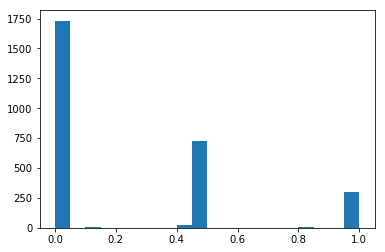

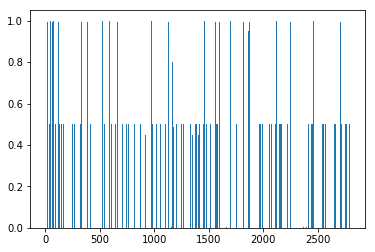

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
Optimization terminated successfully.
         Current function value: 4182.213294
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 3.29293033  0.80240776  3.54276763  3.57746115  2.57487472  2.54625167
  4.16422647]
train iteration: 1


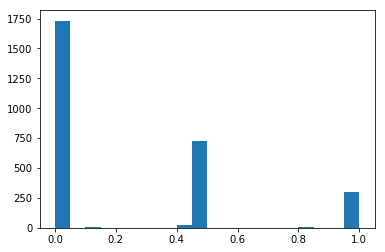

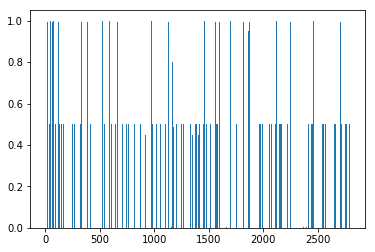

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)
test:


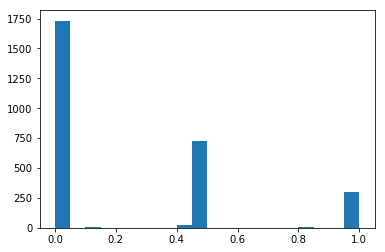

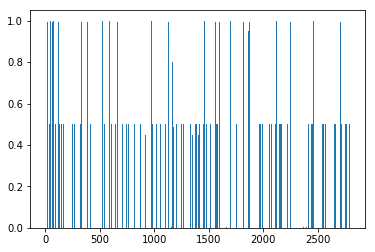

(2796, 2796, 2796)
(0.13274336283185842, 0.68877551020408168, 0.22258862324814513, None)


In [11]:
# All LF_Threshold =0.3 and softmax_Threshold=0.3 ,to be run
train(2,Use_Confidence=False,theta_file_name="THETA")

test(THETA)

In [ ]:
def print_details(label,THETA,LAMDA,SCORE):
    print(label)
    P_cap = get_P_cap(LAMDA,SCORE,THETA)
    marginals=get_marginals(P_cap)
    plt.hist(marginals, bins=20)
    plt.show()
    #plt.bar(range(0,2796),marginals)
    #plt.show()
    predicted_labels=predict_labels(marginals)
    print(len(marginals),len(predicted_labels),len(gold_labels_dev))
    #score(predicted_labels,gold_labels_dev)
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
    
def predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<0.5):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)
    return predicted_labels

#import cPickle as pickle
#THETA = pickle.load( open( "THETA.p", "rb" ) )
#test(THETA)
#LAMDA,SCORE = get_LAMDA(dev_cands)
#Confidence = get_Confidence(LAMDA)

#P_cap = get_P_cap(LAMDA,SCORE,THETA)
#marginals=get_marginals(P_cap)
#plt.hist(marginals, bins=20)
#plt.show()
#plt.bar(range(0,888),train_marginals)
#plt.show()

print_details("dev set",THETA,dev_LAMDA,dev_SCORE)
predicted_labels=predict_labels(marginals)


sorted_predicted_labels=[x for (y,x) in sorted(zip(Confidence,predicted_labels))] #sort Labels as per Confidence
sorted_predicted_labels=list(reversed(sorted_predicted_labels))


for i,j in enumerate(reversed(sorted(zip(Confidence,predicted_labels,gold_labels_dev)))):
    if i>20:
        break
    print i,j
#print(len(marginals),len(predicted_labels),len(gold_labels_dev))
#no_of_labels=186#int(len(predicted_labels)*0.1)  #54 - >0.2  , 108>= 0.15 , 186>= 0.12
#print(len(sorted_predicted_labels[0:no_of_labels]))
no_of_labels=2796
score(predicted_labels[0:no_of_labels],gold_labels_dev[0:no_of_labels])
